In [667]:
#importing required libraries
import pandas as pd
import numpy as np
import zipfile
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Data Wrangling
## Gathering Data

In [668]:
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [669]:
# Downloading and saving the image prediction data using Requests
url ='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]
response = requests.get(url)
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(response.content)

In [670]:
Image_predictions_df = pd.read_csv('image-predictions.tsv' , sep ='\t')
Image_predictions_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [671]:
# Extracting json file from zip
with zipfile.ZipFile('tweet-json.zip' , 'r') as myzip :
    myzip.extractall()

In [672]:
#importing json file and extacting tweet ID, retweet count, and favorite count
df_list = []

with open('tweet-json copy', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count})
        
api_df = pd.DataFrame(df_list)
api_df.head(2)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819


## Accessing Data

### Data Quality issues
#### archive_df :
- consistency issue : unnessary data (retweet_status_id , retweet_status_user_id ,in_reply_to_status_id , in_reply_to_user_id , retweeted_status_timestamp)
- consistency issue : timestamp is a string , not a date time object
- completeness issue : Alot of the dogs are not classified
- completeness issue : missing urls
- completeness issue : discrepancy in the number of tweets between the archive_df dataset and the image_prediction_df.
- Validity issue : Some tweets are actually retweets and replies not original tweets
- Validity issue : null values are written as string (None)
- Accuracy issue : names are not extracted correctly from Name Column 
- Accuracy issue : Some rating numerators don't follow The unique rating system is of WeRateDogs.


### tidiness issues
- (doggo, floofer, pupper, puppo) these Column headers are values, not variable names , columns should be united under a classification column
- Multiple types of observational units are stored in the same table (Image_predictions_df) ,jpg_url and img_num should be separated

In [673]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [674]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [675]:
archive_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [676]:
archive_df.shape

(2356, 17)

In [677]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [678]:
Image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [679]:
Image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### p1_dog is whether or not the #1 prediction is a breed of dog (boolean), and so is p2_dog and p3_dog .  Consequently we cancheck for false values and what are the predictions for those entries.

In [680]:
df_false = Image_predictions_df.query('p1_dog==False')
df_false

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2026,882045870035918850,https://pbs.twimg.com/media/DD2oCl2WAAEI_4a.jpg,1,web_site,0.949591,False,dhole,0.017326,False,golden_retriever,0.006941,True
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False


##### What is the most predicted breed for each prediction level ?

In [681]:
print('The most predicted breed for 1st prediction level is {}'.format(Image_predictions_df.p1.mode()[0]))
print('The most predicted breed for 2nd prediction level is {}'.format(Image_predictions_df.p2.mode()[0]))
print('The most predicted breed for 3rd prediction level is {}'.format(Image_predictions_df.p3.mode()[0]))

The most predicted breed for 1st prediction level is golden_retriever
The most predicted breed for 2nd prediction level is Labrador_retriever
The most predicted breed for 3rd prediction level is Labrador_retriever


#### Can we examine the confidence of each prediction ('p1_conf', 'p2_conf', 'p3_conf') statistically.

In [682]:
print('The confidence for 1st prediction level is {}'.format(Image_predictions_df.p1_conf.mean()))
print('The confidence for 2nd prediction level is {}'.format(Image_predictions_df.p2_conf.mean()))
print('The confidence for 3rd prediction level is {}'.format(Image_predictions_df.p3_conf.mean()))

The confidence for 1st prediction level is 0.5945482636144582
The confidence for 2nd prediction level is 0.13458860950039184
The confidence for 3rd prediction level is 0.06032416861810645


In [683]:
api_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [684]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


#### Can we examine the 'retweet_count', 'favorite_count' and any other chosen data like 'followers_count' statistically

In [685]:
api_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


# Data cleaning

In [686]:
# making copies of the data before cleaning
archive_df_clean = archive_df.copy()
api_df_clean = api_df.copy()
Image_predictions_df_clean = Image_predictions_df.copy()

## Define
- delete tweets which is originaly a retweet or a reply
- drop (retweet_status_id , retweeted_status_user_id ,in_reply_to_status_id , in_reply_to_user_id , retweeted_status_timestamp)
- change timestamp to a datetime object
- matching number of tweets in the 3 tables and removing extra tweets
- combine (doggo, floofer, pupper, puppo) under dog breed column
- Remove 'None' and 'a' from name column
- separate jpg_url and img_num from Image_predictions_df to a separate table
- combine archive , image prediction and api table into 1 table 


## Code and Test

In [687]:
# delete tweets which is originaly a retweet or a reply
archive_df_clean = archive_df_clean.query('in_reply_to_user_id == "NaN"')
archive_df_clean = archive_df_clean.query('retweeted_status_user_id == "NaN"')
# Test 
archive_df_clean.in_reply_to_user_id.value_counts() ,archive_df_clean.retweeted_status_user_id.value_counts()

(Series([], Name: in_reply_to_user_id, dtype: int64),
 Series([], Name: retweeted_status_user_id, dtype: int64))

In [688]:
# drop (retweet_status_id , retweeted_status_user_id ,in_reply_to_status_id , in_reply_to_user_id , retweeted_status_timestamp)
archive_df_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'] , axis = 1 , inplace = True)
archive_df_clean.head(0)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [689]:
# mathing number of tweets in the 3 tables and removing extra tweets
# checking the image_predictions table for extra tweet ids not in the archive table.
# and deleting these extra tweets 
n =0
extra_tweets_list =[]
for x in list(Image_predictions_df_clean.tweet_id) :
    if x not in list(archive_df_clean.tweet_id) :
        extra_tweets_list.append(int(Image_predictions_df_clean[Image_predictions_df_clean['tweet_id']==x].index[0]))
Image_predictions_df_clean.drop(extra_tweets_list , inplace = True)
# Test
for x in list(Image_predictions_df_clean.tweet_id) :
    if x not in list(archive_df_clean.tweet_id) :
        n = n+1
print(n)     


0


In [690]:
# Deleting tweets that has no images (not in Image_predictions table )
n =0
no_image_tweets_list =[]
for x in list(archive_df_clean.tweet_id) :
    if x not in list(Image_predictions_df_clean.tweet_id) :
        no_image_tweets_list.append(int(archive_df_clean[archive_df_clean['tweet_id']==x].index[0]))
archive_df_clean.drop(no_image_tweets_list , inplace = True)
# Test
for x in list(archive_df_clean.tweet_id) :
    if x not in list(Image_predictions_df_clean.tweet_id) :
        n = n+1
print(n)      


0


In [691]:
# Removing extra tweets from api table
n =0
extra_list =[]
for x in list(api_df_clean.tweet_id) :
    if x not in list(archive_df_clean.tweet_id) :
        extra_list.append(int(api_df_clean[api_df_clean['tweet_id']==x].index[0]))
api_df_clean.drop(extra_list , inplace = True)
# Test
for x in list(api_df_clean.tweet_id) :
    if x not in list(archive_df_clean.tweet_id) :
        n = n+1
print(n)      

0


In [692]:
# change timestamp to a datetime object
archive_df_clean['timestamp'] = pd.to_datetime(archive_df_clean['timestamp'])
# test
archive_df_clean.timestamp.dtypes

datetime64[ns, UTC]

In [693]:
# combine (doggo, floofer, pupper, puppo) under dog breed column
archive_df_clean.doggo =archive_df_clean.doggo.str.replace('None' ,'')
archive_df_clean.floofer =archive_df_clean.floofer.str.replace('None' ,'')
archive_df_clean.pupper =archive_df_clean.pupper.str.replace('None' ,'')
archive_df_clean.puppo =archive_df_clean.puppo.str.replace('None' ,'')

archive_df_clean['dog_breed'] = archive_df_clean['doggo'] +archive_df_clean['floofer']+archive_df_clean['pupper']+ archive_df_clean['puppo'] 
archive_df_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'],axis =1 , inplace =True)

archive_df_clean.loc[archive_df_clean.dog_breed == 'doggopupper', 'dog_breed'] = 'doggo-pupper'
archive_df_clean.loc[archive_df_clean.dog_breed == 'doggofloofer', 'dog_breed'] = 'doggo-floofer'
archive_df_clean.loc[archive_df_clean.dog_breed == 'doggopuppo', 'dog_breed'] = 'doggo-puppo'

archive_df_clean.dog_breed =archive_df_clean.dog_breed.replace('' ,np.nan)
# Test
archive_df_clean.dog_breed.value_counts()

pupper           201
doggo             63
puppo             22
doggo-pupper       8
floofer            7
doggo-floofer      1
doggo-puppo        1
Name: dog_breed, dtype: int64

In [694]:
# Removing 'None' and 'a' from name column
archive_df_clean.name=archive_df_clean.name.str.replace('None','')
archive_df_clean.name =archive_df_clean.name.str.replace('a','')

archive_df_clean.name =archive_df_clean.name.replace('',np.nan)
archive_df_clean.name =archive_df_clean.name.replace('',np.nan)
# test
archive_df_clean.name.value_counts()

Chrlie       11
Cooper       10
Oliver       10
Lucy         10
Penny         9
             ..
Hermione      1
Keurig        1
Hzel          1
Pippin        1
Genevieve     1
Name: name, Length: 929, dtype: int64

In [695]:
Image_predictions_df.head(0)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [696]:
# separate jpg_url and img_num from Image_predictions_df to a separate table
images = {'img_num' : list(Image_predictions_df.img_num) ,'jpg_url' : list(Image_predictions_df.jpg_url)}
images_df = pd.DataFrame(images , columns = ['img_num','jpg_url'])
# test
images_df.head(3)

,img_num,jpg_url
0,1,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg
1,1,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg
2,1,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg


In [697]:
archive_df_clean.head(0) ,api_df_clean.head(0),Image_predictions_df_clean.head(0)

(Empty DataFrame
 Columns: [tweet_id, timestamp, source, text, expanded_urls, rating_numerator, rating_denominator, name, dog_breed]
 Index: [],
 Empty DataFrame
 Columns: [tweet_id, retweet_count, favorite_count]
 Index: [],
 Empty DataFrame
 Columns: [tweet_id, jpg_url, img_num, p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog]
 Index: [])

In [698]:
# combine archive , image prediction and api table into 1 table 
archive_df_clean = pd.merge(archive_df_clean , Image_predictions_df  , on =['tweet_id'] , how ='right' )
archive_df_clean = pd.merge(archive_df_clean , api_df_clean  , on =['tweet_id'] , how ='right' )
# test
archive_df_clean.head(0)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_breed,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


## Storing

In [699]:
archive_df_clean.to_csv('twitter_archive_master.csv' , index = False)

# Data analyzing and visualizing

In [700]:
archive_df_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_breed',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

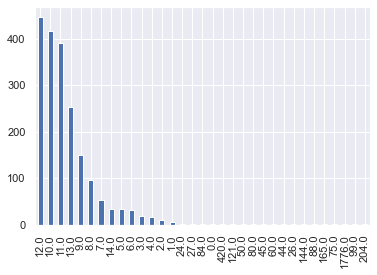

In [701]:
archive_df_clean.rating_numerator.value_counts().plot(kind = 'bar');

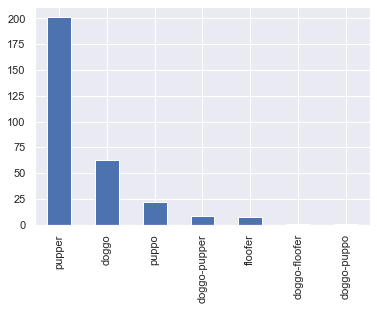

In [702]:
archive_df_clean.dog_breed.value_counts().plot(kind = 'bar');

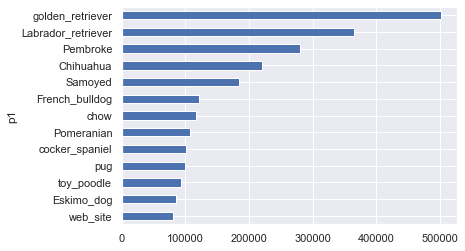

In [703]:
archive_df_clean.groupby(['p1']).retweet_count.sum().sort_values(ascending=False)[12::-1].plot(kind='barh');

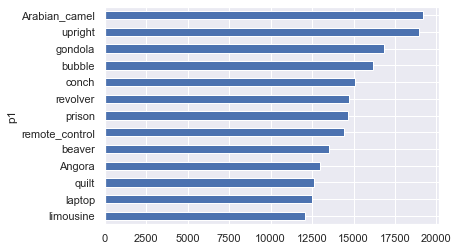

In [704]:
archive_df_clean.groupby(['p1']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh');

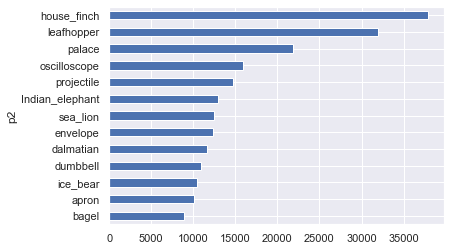

In [705]:
archive_df_clean.groupby(['p2']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh');

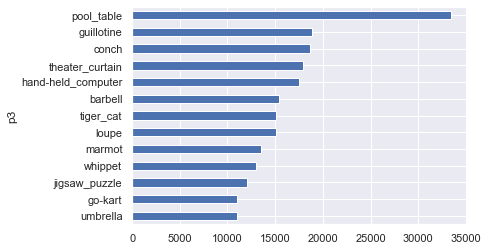

In [706]:
archive_df_clean.groupby(['p3']).retweet_count.mean().sort_values(ascending=False)[12::-1].plot(kind='barh');

ValueError: shape mismatch: objects cannot be broadcast to a single shape

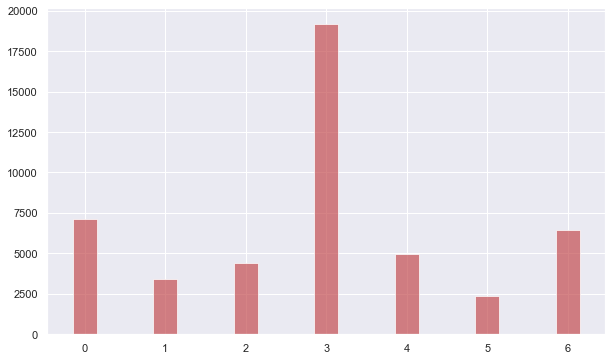

In [707]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
avg_retweet_count_dog_stage = archive_df_clean.groupby('dog_breed').retweet_count.mean()
width=0.3
ind1 = np.arange(len(avg_retweet_count_dog_stage))
ind2 = np.arange(len(avg_favorite_count_dog_stage))

avg_favorite_count_dog_stage = archive_df_clean.groupby('dog_breed').favorite_count.mean() 

retweet_count_bars = plt.bar(ind1, avg_retweet_count_dog_stage , width, color='r', alpha=.7, label='Retweet count')
favorite_count_bars = plt.bar(ind2 + width, avg_favorite_count_dog_stage, width, color='b', alpha=.7, label='Favourite count')

plt.title('interactions with different dog stages')
locations = ind + width / 2 
labels = (avg_retweet_count_dog_stage.index )
 
plt.xticks(locations, labels )

plt.legend();

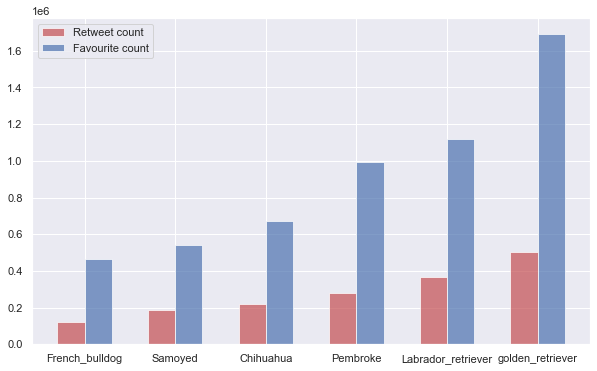

In [708]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
avg_retweet_count_dog_stage = archive_df_clean.groupby('p1').retweet_count.sum().sort_values(ascending=False)[5::-1]
width=0.3
avg_favorite_count_dog_stage = archive_df_clean.groupby('p1').favorite_count.sum().sort_values(ascending=False)[5::-1] 
ind1 = np.arange(len(avg_retweet_count_dog_stage))
ind2 = np.arange(len(avg_favorite_count_dog_stage))



retweet_count_bars = plt.bar(ind1, avg_retweet_count_dog_stage , width, color='r', alpha=.7, label='Retweet count')
favorite_count_bars = plt.bar(ind2 + width, avg_favorite_count_dog_stage, width, color='b', alpha=.7, label='Favourite count')


locations = ind1 + width / 2 
labels = (avg_retweet_count_dog_stage.index )
 
plt.xticks(locations, labels )

plt.legend();

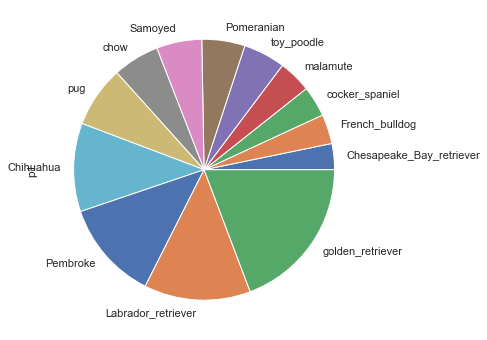

In [709]:
archive_df_clean.p1.value_counts().sort_values(ascending=False)[12::-1].plot(kind ='pie');

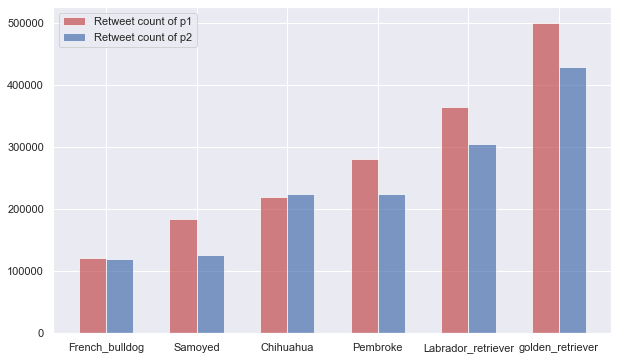

In [710]:
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
avg1 = archive_df_clean.groupby('p1').retweet_count.sum().sort_values(ascending=False)[5::-1]
width=0.3
avg2 = archive_df_clean.groupby('p2').retweet_count.sum().sort_values(ascending=False)[5::-1] 
ind1 = np.arange(len(avg1))
ind2 = np.arange(len(avg2))



retweet_count_bars = plt.bar(ind1, avg1 , width, color='r', alpha=.7, label='Retweet count of p1')
favorite_count_bars = plt.bar(ind2 + width, avg2, width, color='b', alpha=.7, label='Retweet count of p2')


locations = ind1 + width / 2 
labels = (avg_retweet_count_dog_stage.index )
 
plt.xticks(locations, labels )

plt.legend();